# Cyclic Loading of (2D plate)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import copy

In [2]:
# Material properties
# YM: Young's Modulus [N/mm²]
# v: Poisson's ratio
# sigma_y: initial yield limit [N/mm²]
Young_Mod, v, sigma_y = 1e5, 0, 500

E = (Young_Mod/(1-v**2))*np.array([[1, v, 0],
                                   [v, 1, 0],
                                   [0, 0, (1-v)/2] ])

## Isotropic hardening
# Q_iso: Isotropic asymptote [N/mm²]
# n_iso: exponent 
# b_iso: growth rate
# D_iso: limit [N/mm²]
Q_iso, n_iso, b_iso, D_iso = 80, 3, 10, 170

## Kinematic hardening
# Q_kin = Kinematic asymptote [N/mm²]
# b_kin: growth rate
Q_kin, b_kin = 70, 30

M = np.array([[1, -0.5, 0],
              [-0.5, 1, 0],
              [0, 0, 3] ])
              
M1 = copy.deepcopy(M)

# strain rate vector
strain_rate = np.array([[1e-4],
                        [0],
                        [0] ])

# maximum displace in x direction [m]
u_x_max = 1.2e-2

# inital length of bar [m]
l_0 = 2

time_to_u_x_max = u_x_max/(strain_rate[0]*l_0)

In [3]:
def strain(t):
    return strain_rate*t if t < time_to_u_x_max else np.array([[u_x_max/l_0],[0],[0]])

In [4]:
def func_strain_rate(t):
    return strain_rate if t < time_to_u_x_max else np.zeros((3,1))

In [5]:
def equivalent_stress(sigma, backstress):

    sigma_xx = sigma[0] - backstress[0]
    sigma_yy = sigma[1] - backstress[1]
    sigma_xy = sigma[2] - backstress[2]

    return np.sqrt(sigma_xx**2 - sigma_xx*sigma_yy + sigma_yy**2 + 3*sigma_xy**2)

In [6]:
def sigma_macaulay(sigma, backstress, K, power):

    sigma_ex = equivalent_stress(sigma, backstress) - (sigma_y + K)

    return (sigma_ex/D_iso)**power if sigma_ex > 0 else 0

# Explicit scheme 

$\left[\begin{array}{c}
\boldsymbol{\sigma}_{i+1} \\
K_{i+1} \\
\boldsymbol{X}_{i+1}
\end{array}\right] = 
\left[\begin{array}{c}
\boldsymbol{\sigma}_{i} + \boldsymbol{E} \cdot \Delta t \cdot\Bigg \{ {\boldsymbol{\varepsilon}}_{i} - \frac{1}{\sigma_{v, i}} \cdot\left\langle\frac{\sigma_{ex, i}}{D}\right\rangle^{n} \cdot \dot{{\boldsymbol\varepsilon}}_{0} \cdot \boldsymbol{M} \cdot (\boldsymbol{\sigma}_{i} - \boldsymbol{X}_{i}) \Bigg \} \\
K_{i} + \Delta t \cdot b_{iso} \cdot(Q_{iso}-K_{i}) \cdot\left\langle\frac{\sigma_{ex, i}}{D}\right\rangle^{n} \\
\boldsymbol{X}_{i} + \Delta t \cdot b_{kin} \Big(\frac{2}{3} Q_{kin} \cdot \frac{1}{\sigma_{v}} \boldsymbol{M} \cdot (\boldsymbol{\sigma}_{i} - \boldsymbol{X}_{i}) - \boldsymbol{X}_{i} \Big) \cdot \left\langle\frac{\sigma_{e x}}{D}\right\rangle^{n}
\end{array}\right]$


In [7]:
# time integration from 0 to 5000 [s]
t_min = 0
t_max = 100
delta_t = 0.01 # time step
N = int((t_max-t_min)/delta_t)
T = np.linspace(t_min,t_max,N+1)

# initialise variables
t_i = 0
K_i = 0
X_i = np.zeros((3,1))
sigma_i = np.ones((3,1))*1e-15

store_values = np.zeros((N+1,3))
strain_linspace = np.zeros((N+1))


for i in range(N):

    sigma_i = sigma_i + delta_t * E @  \
              (func_strain_rate(t_i)- (1/equivalent_stress(sigma_i, X_i)) * sigma_macaulay(sigma_i, X_i, K_i, n_iso) \
              * M @ (sigma_i - X_i))

    K_i = K_i + delta_t * b_iso * (Q_iso-K_i) * sigma_macaulay(sigma_i, X_i, K_i, n_iso)

    X_i = X_i + delta_t * b_kin * ( (2/3) * Q_kin * (1/equivalent_stress(sigma_i, X_i))* M @ (sigma_i - X_i) - X_i) * sigma_macaulay(sigma_i, X_i, K_i, n_iso)

    # store stress, isotropic, kinematic hardening
    store_values[i+1, 0] = equivalent_stress(np.copy(sigma_i), X_i)
    store_values[i+1, 1] = K_i
    store_values[i+1, 2] = X_i[0][0]
    strain_linspace[i+1] = strain(t_i)[0]
    
    # update variables
    t_i += delta_t

# Stress vs Time Plot

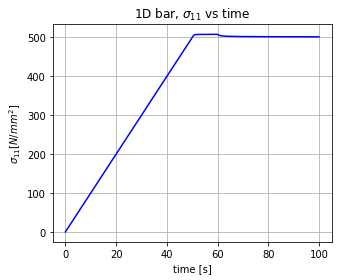

In [8]:
fig, ax = plt.subplots(figsize=(5,4))

ax.plot(T, store_values[:,0], color = 'blue')

ax.set_title(r'1D bar, $\sigma_{11}$ vs time')
ax.set_xlabel('time [s]')
ax.set_ylabel(r'$\sigma_{11} [N/mm^2]$')
ax.grid()

plt.show()

# Strain vs time

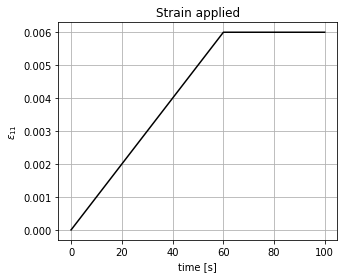

In [9]:
fig, ax = plt.subplots(figsize=(5,4))

ax.plot(T, strain_linspace, color = 'black')

ax.set_title(r'Strain applied')
ax.set_xlabel('time [s]')
ax.set_ylabel(r'$\varepsilon_{11}$')
ax.grid()

plt.show()

# Stress vs Strain

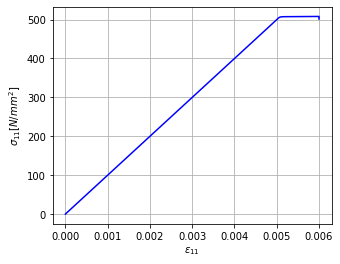

In [10]:
fig, ax = plt.subplots(figsize=(5,4))

ax.plot(strain_linspace, store_values[:,0], color = 'blue')

ax.set_xlabel(r'$\varepsilon_{11}$')
ax.set_ylabel(r'$\sigma_{11} [N/mm^2]$')

ax.grid()
plt.show()

# Isotropic and Kinematic Hardening

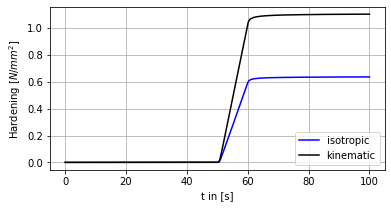

In [11]:
fig, ax = plt.subplots(figsize=(6,3))

ax.plot(T, store_values[:,1], color = 'blue', label = 'isotropic')
ax.plot(T, store_values[:,2], color = 'black', label = 'kinematic')

ax.set_ylabel(r'Hardening $[N/mm^2]$')
ax.set_xlabel('t in [s]')
ax.legend(loc = 'lower right')
ax.grid()

plt.show()